<a href="https://colab.research.google.com/github/jlc248/satellite-resources/blob/main/MTG_Lightning_Imager_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTG Lightning Imager data visualization

Lightning is a frequent hazard for most locations of the world. Its detection and observation is important for public safety and meteorological research.

According to [EUMETSAT](https://www.eumetsat.int/ISS-LIS-data-analysis), *“Lightning is a source of different types of signals in the electromagnetic spectrum. In detail: Very High Frequency signals (VHF), Very Low Frequency signals (VLF), Low Frequency signals (LF), and finally optical pulses. These signals can be detected by different type of instruments and can be employed for the location in space and time of lightning, as well as for their physical characterisation. Different instruments are capable of detecting either a part of or all the lightning categories listed above.”*

The Meteosat Third Generation (MTG) Lightning Imager (LI) detects the optical pulses of lightning. One advantage of spaceborne lightning imagers is that they often have a more uniform field of view and (to some extent) detection efficiency over much of that field of view. However, they cannot directly discern in-cloud lightning vs. cloud-to-ground lightning like many ground-based networks are able to.

This notebook shows how to visualize point data from MTG-LI. It is largely based off this [Medium article](https://medium.com/@lubomirfranko/near-real-time-lightning-data-visualisation-with-python-d85f42e9224a) with some modifications and bug-fixing.

## Install libraries

In [2]:
!pip install satpy xarray h5py pandas matplotlib eumdac requests cartopy netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Set up `eumdac` keys

You need a EUMETSAT account and associated keys to run grab data. After [creating an account](https://eoportal.eumetsat.int/cas/login), you can find your "consumer key" and "consumer secret" here: `https://api.eumetsat.int/api-key/`. Copy them and paste them into the code below.

In [3]:
# Import EUMDAC and dependent libraries to begin
import eumdac
import datetime
import shutil
import requests

# Insert your personal key and secret into the single quotes
consumer_key = '<your-consumer-key>'
consumer_secret = '<your-consumer-secret>'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

This token '68832357-c141-3957-9561-a07aeec583c9' expires 2024-11-12 13:25:29.487269


## Download data

Point-based LI data comes in 3 types — lightning events, flashes and groups. See [here](https://resources.eumetrain.org/data/3/362/362.pdf) for more information. To download the flash data into directory `point_data`, run the following code:

In [4]:
datastore = eumdac.DataStore(token)

import os
import zipfile
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed

# Assume datastore is already defined and connected
searchs = datastore.opensearch("""pi=EO:EUM:DAT:0691&dtstart=2024-07-30T22:00:00&dtend=2024-07-31T22:00:00""")

# Create the data directory if it doesn't exist
os.makedirs("point_data", exist_ok=True)

def download_and_extract(product):
    try:
        # Create a temporary BytesIO object to hold the downloaded zip file
        with product.open() as fsrc:
            with BytesIO(fsrc.read()) as bio:
                with zipfile.ZipFile(bio, 'r') as zip_ref:
                    # Check if all the files to be extracted already exist
                    all_files_exist = all(os.path.exists(os.path.join("point_data", name)) for name in zip_ref.namelist())
                    if all_files_exist:
                        print(f"All files already exist, skipping download for product: {product}")
                        return
                    # Extract all the contents into the data directory
                    zip_ref.extractall("point_data")
                    print(f'Extracted product finished.')
    except Exception as e:
        print(f"Failed to process product: {e}")

# Use ThreadPoolExecutor to handle concurrency
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = {executor.submit(download_and_extract, product): product for product in searchs}
    for future in as_completed(futures):
        product = futures[future]
        try:
            future.result()
        except Exception as e:
            print(f"Exception occurred while processing product: {e}")

print("All products processed.")

Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product finished.
Extracted product fi

In [5]:
!ls point_data | head

EOPMetadata.xml
manifest.xml
quicklooks
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240730220016_L2PF_OPE_20240730215007_20240730220007_N__T_0132_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240730221016_L2PF_OPE_20240730220007_20240730221007_N__T_0133_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240730222016_L2PF_OPE_20240730221007_20240730222007_N__T_0134_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240730223016_L2PF_OPE_20240730222007_20240730223007_N__T_0135_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240730224016_L2PF_OPE_20240730223007_20240730224007_N__T_0136_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-NC4E_C_EUMT_20240730225016_L2PF_OPE_20240730224007_20240730225007_N__T_0137_0001.nc
W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+LI-2-LFL--FD--CHK-BODY--ARC-N

## Visualize the Data

Here, we use the `Satpy` library to load point data. We then convert to a `xarray` dataset and finally to a `pandas.DataFrame` with only the fields that we need.

*N.B.: Sometimes we get an error on this block for unknown reasons ("HDF Error"). Executing the block again usually clears this up.*

In [1]:
from glob import glob
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from satpy import Scene, MultiScene
import matplotlib.patheffects as path_effects

# We batch up the Scene creation due to RAM limitations in Colab
from datetime import datetime, timedelta


scn = Scene(filenames=glob(f"point_data/*001.nc"), reader="li_l2_nc",)
scn.load(scn.available_dataset_names())

ds = scn.to_xarray_dataset()

#This wasn't working...
#df = ds.to_dataframe()

# Get longitude and latitude from metadata
#df["lon"], df["lat"] = ds["number_of_events"].attrs["area"].get_lonlats()

lon, lat = ds["number_of_events"].attrs["area"].get_lonlats()
flash_times = ds["flash_time"].to_numpy()
radiance = ds["radiance"].to_numpy()

df = pd.DataFrame({'radiance':radiance, 'flash_time': flash_times, 'lon': lon, 'lat': lat})

# Drop columns that we will not need
#df = df.drop(columns=["flash_filter_confidence"])

# Drop null values (if any)
df.dropna(inplace=True)

# Convert flash_time to datetime
df["flash_time"] = pd.to_datetime(df["flash_time"])

print(df.head())

   radiance                    flash_time        lon     lat
0     270.0 2024-07-30 21:50:06.014499968 -62.972103 -1.6875
1      27.0 2024-07-30 21:50:08.016100096 -64.219505 -2.0115
2      19.0 2024-07-30 21:50:08.174100096 -67.124702 -0.7830
3     102.0 2024-07-30 21:50:09.224099968 -62.880302 -1.8090
4      19.0 2024-07-30 21:50:09.370099968 -65.321098 -2.7162


### Creating lightning-age images

Now we create the PNGs for each aggregated 5 minutes by making a scatterplot. I short-circuit the loop and only do the first 6, but this may take 10 minutes or so if you want to do all of the pngs.

In [10]:
# Create 5 min bins
df["bin_5min"] = df["flash_time"].dt.floor("5min")

# Define plot function
def plot_df(df, minute):
    # Define the map projection
    projection = ccrs.Mercator()
    crs = ccrs.PlateCarree()

    # Create a new figure with a high DPI for better resolution
    plt.figure(dpi=350)
    ax = plt.axes(projection=projection, frameon=True)

    # Set the geographical extent of the map (bounding box)
    # for northern France
    lon_min = -6
    lon_max = 9
    lat_min = 46
    lat_max = 52
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add land and border features to the map
    ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="black")
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), lw=0.3, color="white")
    ax.coastlines()

    # Add Paris location with a small red dot and a label
    paris_lon, paris_lat = 2.3522, 48.8566
    txt = ax.plot(paris_lon, paris_lat, '.', color='red', markersize=3, transform=ccrs.PlateCarree(), zorder=6)
    # Add white outline to the red dot for better visibility
    txt[0].set_path_effects([path_effects.withStroke(linewidth=1, foreground="w", alpha=0.8)])

    # Add a text label for Paris with a white background and black outline
    text = ax.text(
        paris_lon, paris_lat, ' Paris', fontsize=8, alpha=1, ha='left', va='bottom',
        bbox=dict(facecolor='white', alpha=0.1, pad=0.0, edgecolor='none'),
        transform=ccrs.PlateCarree(), zorder=6
    )
    text.set_path_effects([path_effects.withStroke(linewidth=1.5, foreground="w", alpha=0.9)])

    # Plot the data points on the map using seaborn's scatterplot
    sns.scatterplot(
        x="lon",
        y="lat",
        data=df,
        edgecolor=None,
        transform=ccrs.PlateCarree(),
        hue="min_ago",
        palette="YlOrBr",
        s=1,
        ax=ax,
        marker="+",
        hue_norm=(0, 60),
        legend=False,
        linewidths=0.6
    )

    # Set the title of the plot with the current minute
    ax.set_title(f"{minute:%Y-%m-%d %H:%M}")
    # Save the plot as a PNG file in the specified directory
    plt.savefig(f"minute5_lightning/{minute:%Y-%m-%d__%H%M}.png", bbox_inches="tight")
    # Adjust layout to prevent clipping of elements
    plt.tight_layout()
    # Close the plot to free memory
    plt.close()


# Iterate over unique 5-minute intervals
os.makedirs("minute5_lightning", exist_ok=True)

for ii, minute in enumerate(df["bin_5min"].unique()):
    h1_ago = minute - pd.Timedelta(hours=1)
    h5_df = df[(df["bin_5min"] >= h1_ago) & (df["bin_5min"] <= minute)]
    h5_df["min_ago"] = (h5_df["bin_5min"].max() - h5_df["bin_5min"]).dt.seconds / 60
    plot_df(h5_df, minute)

    if ii == 6:
        break # short-circuiting image-creation to save time


<ipython-input-10-3b49e3cba650>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h5_df["min_ago"] = (h5_df["bin_5min"].max() - h5_df["bin_5min"]).dt.seconds / 60
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
<ipython-input-10-3b49e3cba650>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h5_df["min_ago"] = (h5_df["bin_5min"].max() - h5_d

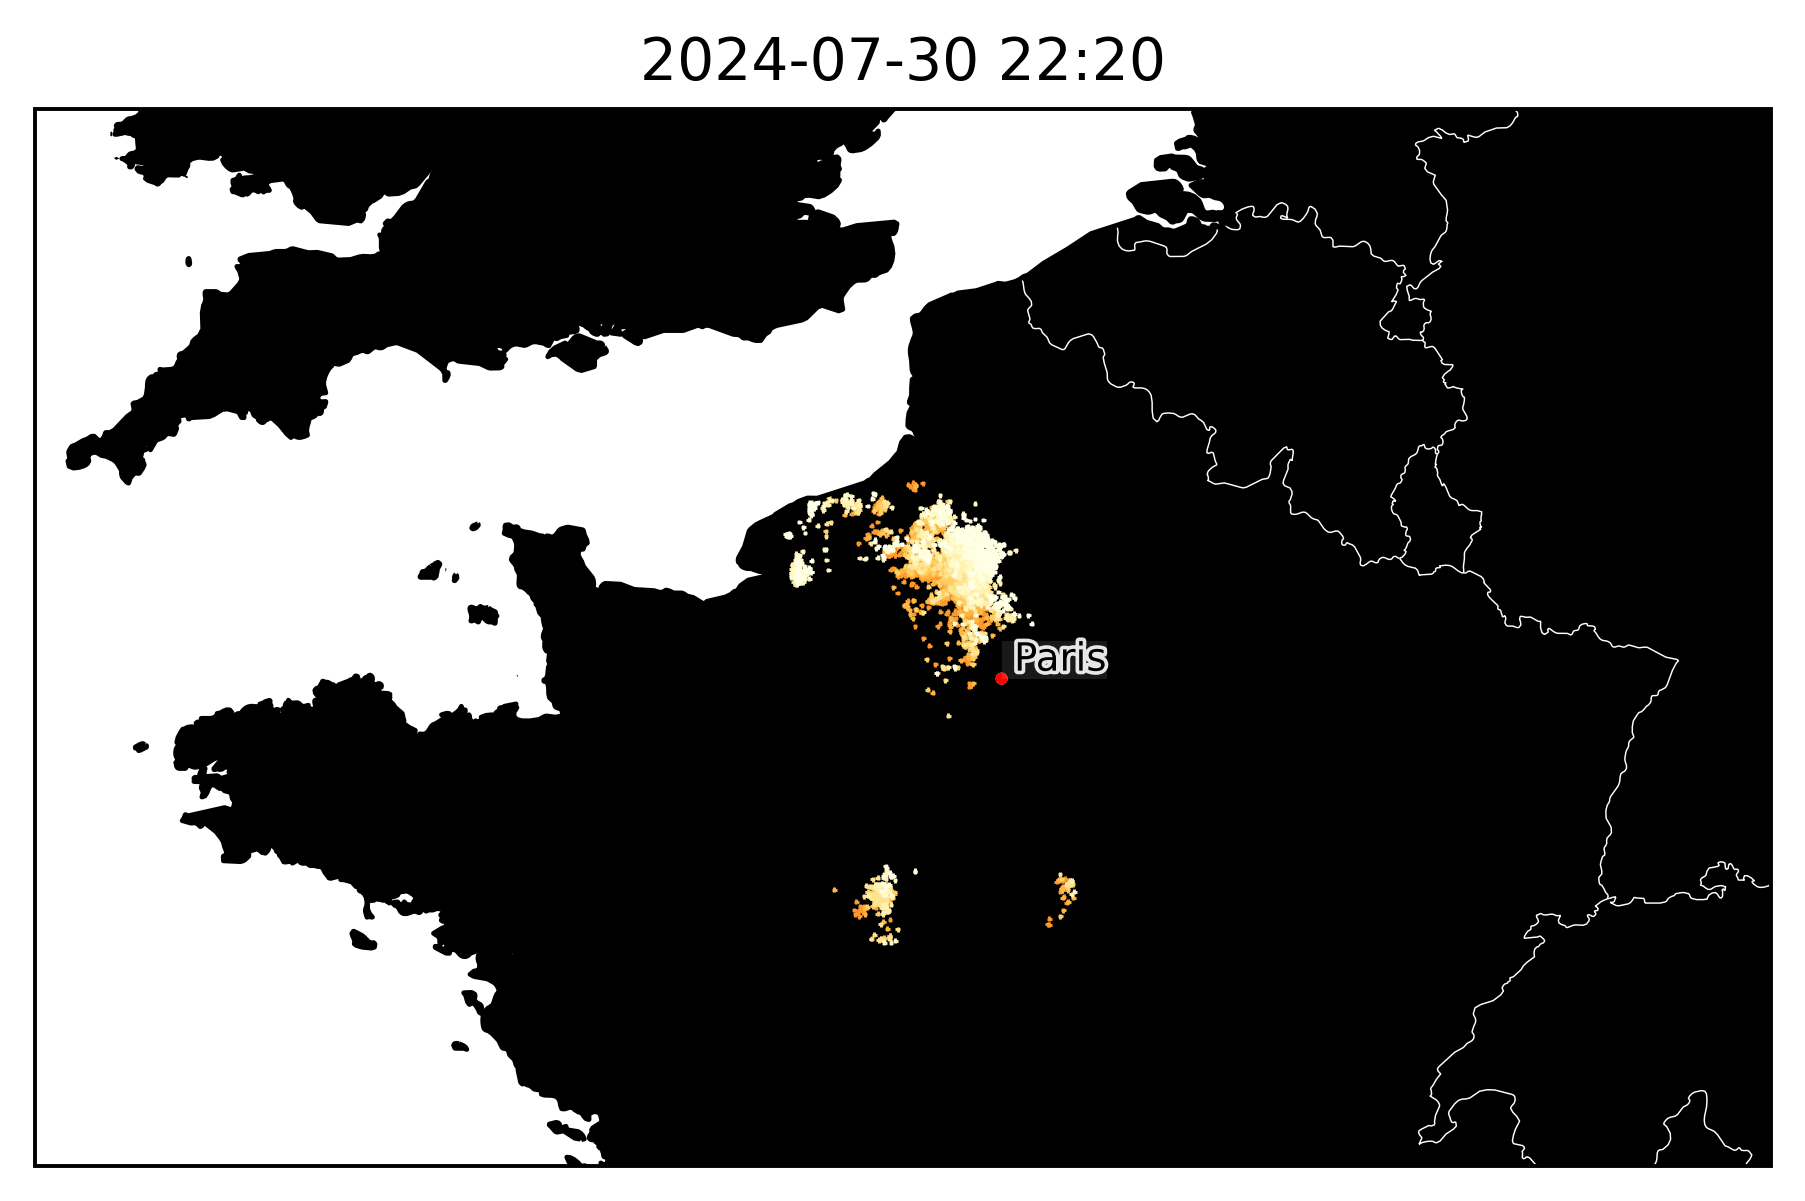

In [13]:
from IPython.display import Image
Image('minute5_lightning/2024-07-30__2220.png', width=800)

### Creating flash-count time series

<ipython-input-14-0b019525db6a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='flash_time', y='flash_count', data=hourly_sums, palette='viridis')


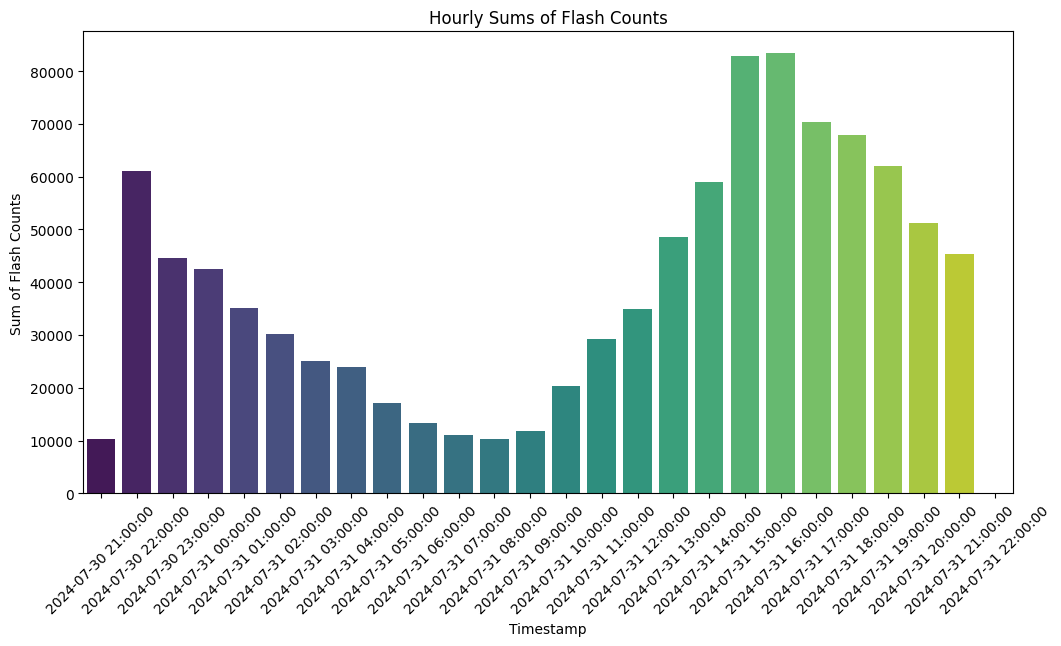

In [14]:
# Setting the index and creating the flash_count column in one step
df_orig = df.set_index('flash_time').assign(flash_count=1)

# Resampling to hourly sums
hourly_sums = df_orig['flash_count'].resample('h').sum().reset_index()

# Creating bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='flash_time', y='flash_count', data=hourly_sums, palette='viridis')
plt.xticks(rotation=45)
plt.title('Hourly Sums of Flash Counts')
plt.xlabel('Timestamp')
plt.ylabel('Sum of Flash Counts')
plt.show()


### Creating radiance distribution time series

We can also make hourly distributions of radiance data.

In [15]:
# Make 'hour' Series and log(radiance)
df['hour'] = df['flash_time'].dt.hour
df['log_radiance'] = np.log(df['radiance'])

<ipython-input-16-2cbd21614c64>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hour', y='log_radiance', data=df, palette='viridis')


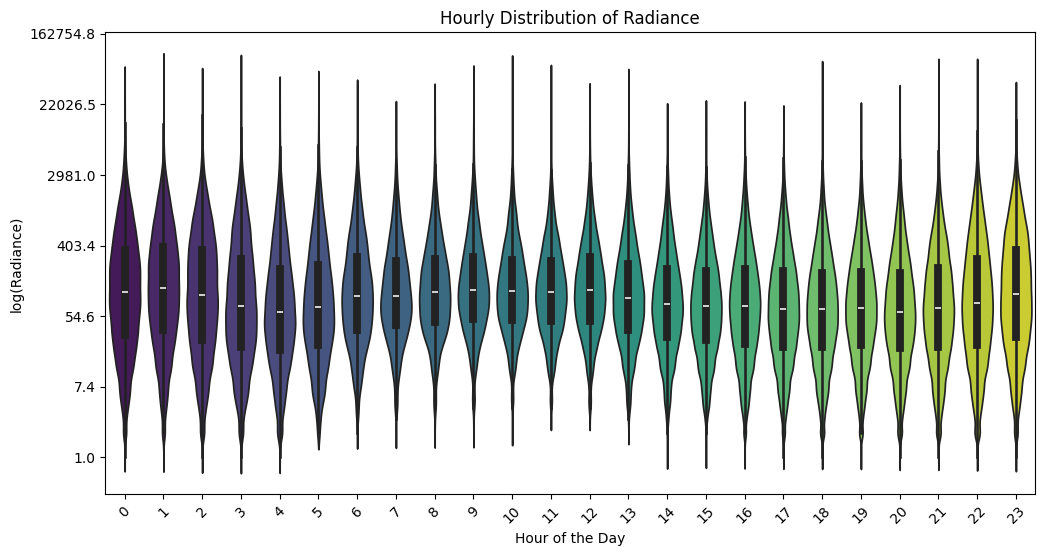

In [16]:
import matplotlib.ticker as ticker

# Creating violin plot of 'log_radiance' by hour
plt.figure(figsize=(12, 6))
sns.violinplot(x='hour', y='log_radiance', data=df, palette='viridis')

# Setting yticks to reflect the log scale
def log_format(x, pos):
    return f'{np.exp(x):.1f}'

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(log_format))

plt.xticks(rotation=45)
plt.title('Hourly Distribution of Radiance')
plt.xlabel('Hour of the Day')
plt.ylabel('log(Radiance)')
plt.show()

Creating spatiotemporal map of flashes

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


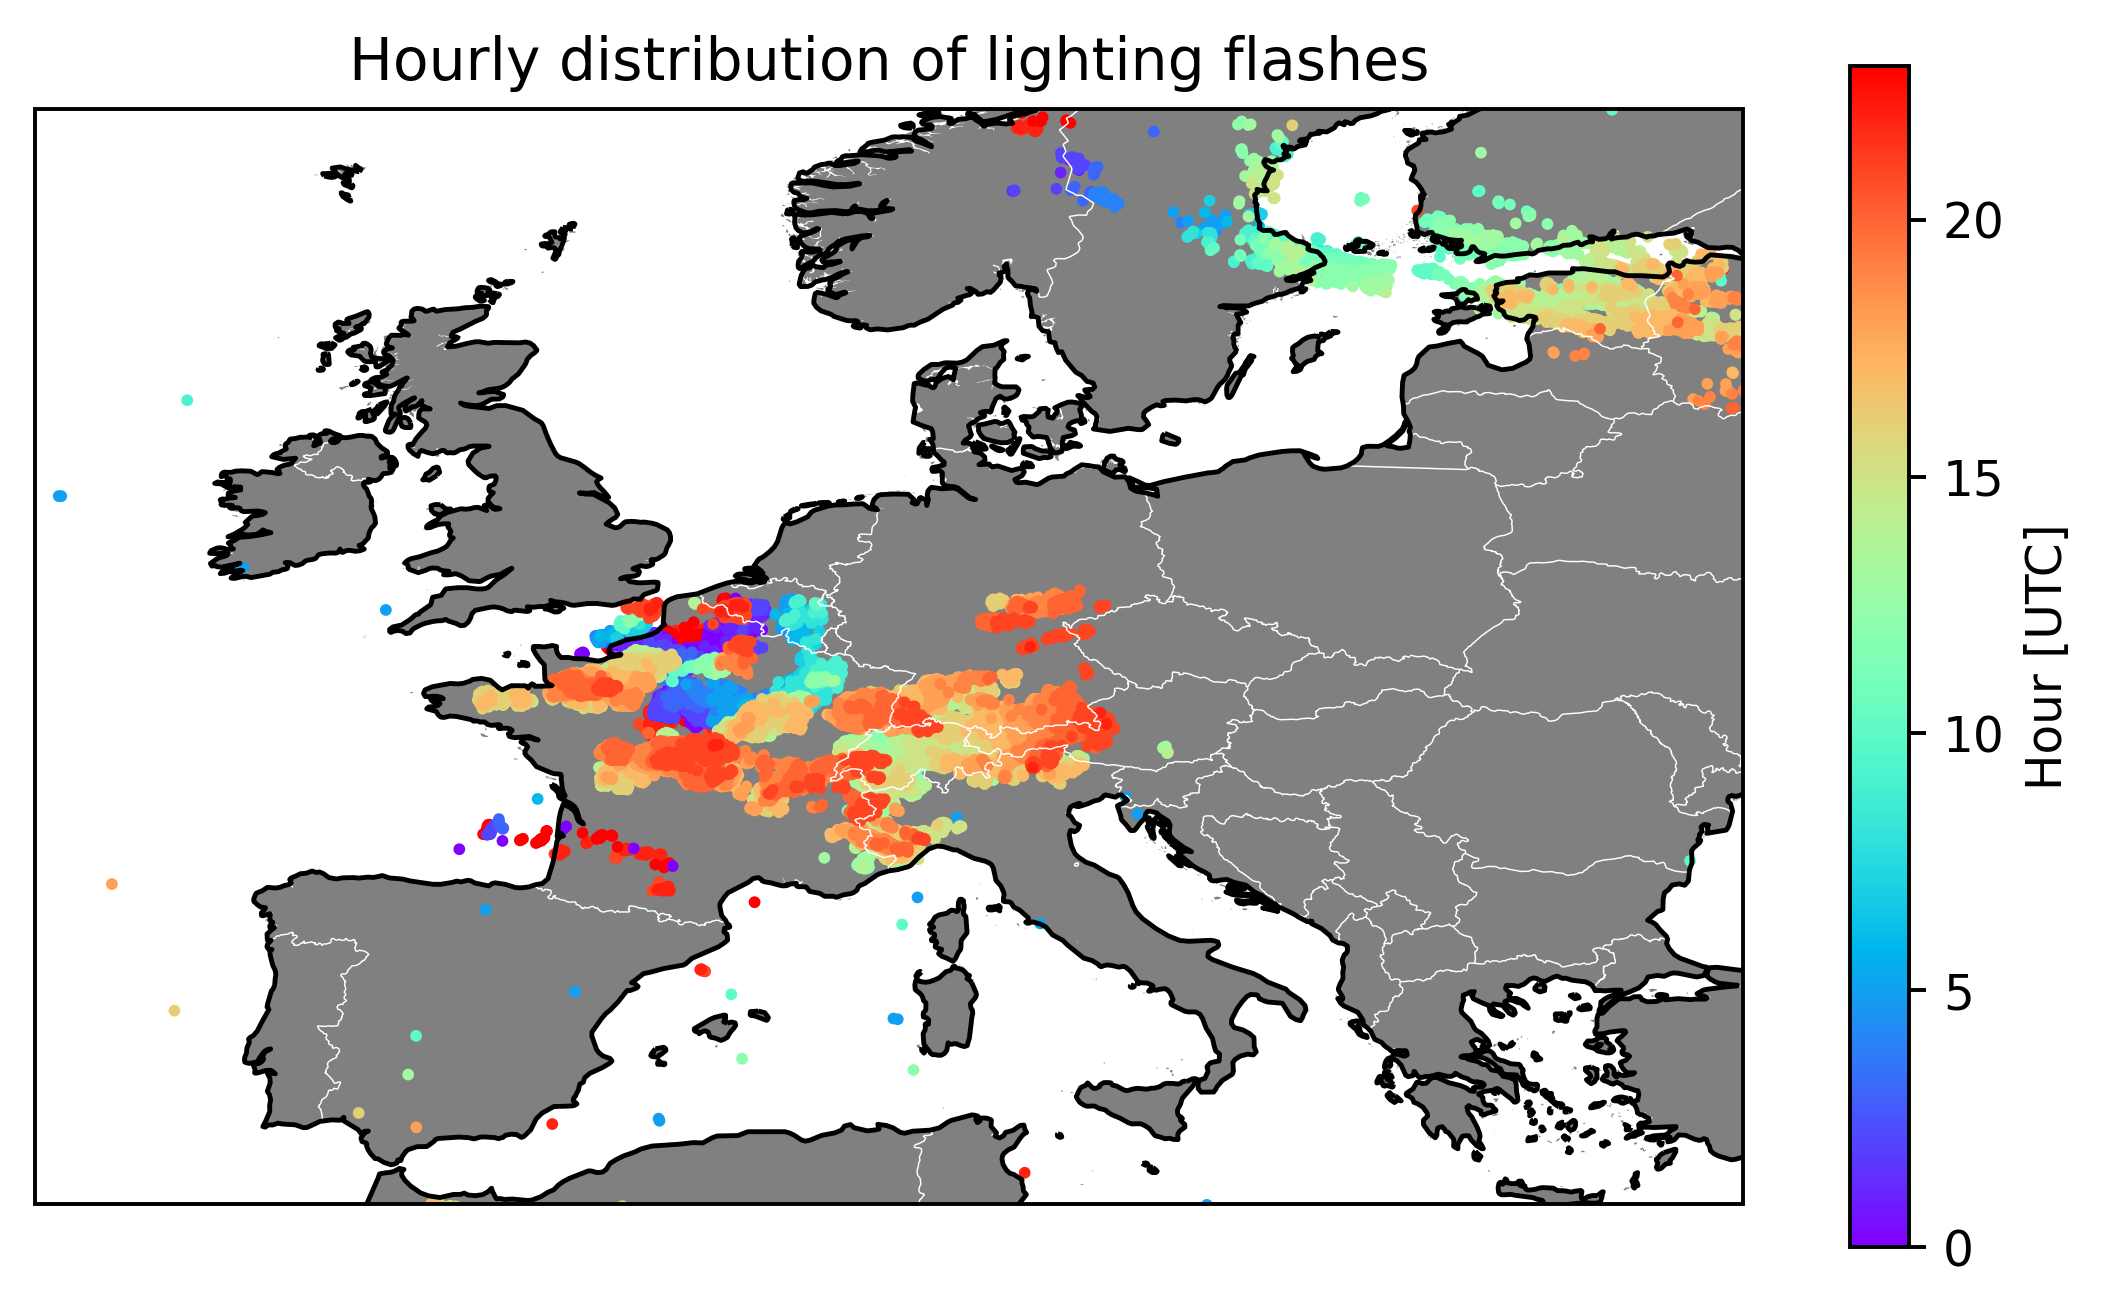

In [38]:
# Define the map projection
#projection = ccrs.Mercator()
crs = ccrs.PlateCarree()

# Create a new figure with a high DPI for better resolution
plt.figure(dpi=350)
ax = plt.axes(projection=crs, frameon=True)

# Set the geographical extent of the map (bounding box)
# for northern France
lon_min = -15
lon_max = 30
lat_min = 35
lat_max = 62
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Add land and border features to the map
ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="gray")
ax.add_feature(cfeature.BORDERS.with_scale("10m"), lw=0.3, color="white")
ax.coastlines()

# Seaborn
# Plot the data points on the map using seaborn's scatterplot
#axs = sns.scatterplot(
#        x="lon",
#        y="lat",
#        data=df,
#        edgecolor=None,
#        transform=ccrs.PlateCarree(),
#        hue="hour",
#        palette="rainbow",
#        s=1,
#        ax=ax,
#        marker="o",
#        hue_norm=(0, 23),
#        legend=False,
#        linewidths=0.6
#)

# Matplotlib
scat = plt.scatter(
          x=np.array(df["lon"]),
          y=np.array(df["lat"]),
          c=np.array(df["hour"]),
          s=2,
          cmap="rainbow",
          vmin=0,
          vmax=23,
          transform=crs
)

# Set the title of the plot with the current minute
ax.set_title("Hourly distribution of lighting flashes")

# Colorbar
plt.colorbar(orientation='vertical', label='Hour [UTC]', shrink=0.75)

# Adjust layout to prevent clipping of elements
plt.tight_layout()

plt.show()